In [2]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
import random
import tifffile as tiff

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

In [ ]:
path="/group/jug/Sheida/maester_data/download/high_c1/"
train_data = tiff.imread(path+"data/train/*.tif")
val_data = tiff.imread(path+"data/validation/*.tif")
test_data = tiff.imread(path+"data/test/*.tif")
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)

In [ ]:
### We extract overlapping patches of size ```patch_size x patch_size``` from training and validation images.
### Usually 64x64 patches work well for most microscopy datasets
patch_size = 64

In [ ]:
img_width = 699
img_height = 760
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)
train_images = utils.extract_patches(train_data, patch_size, num_patches)
val_images = utils.extract_patches(val_data, patch_size, num_patches)
test_images = utils.extract_patches(test_data, patch_size, num_patches)
img_shape = (train_images.shape[1], train_images.shape[2])
print("Shape of training images:", train_images.shape, "Shape of validation images:", val_images.shape)

In [4]:
model_name = "HDN Muller"
directory_path = "./Trained_model/" 

# Data-specific
gaussian_noise_std = None
noiseModel = None 
# Training-specific
batch_size=128
virtual_batch = 64
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
# z_dims = [32, 64, 128, 256, 512]
blocks_per_layer = 5
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated

In [ ]:
debug             = False #[True, False]
save_output       = True #[True, False]
project           = 'HDN_Muller'


In [ ]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,val_images,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape).cuda()

model.train() # Model set in training mode

In [ ]:
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size)

In [5]:
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

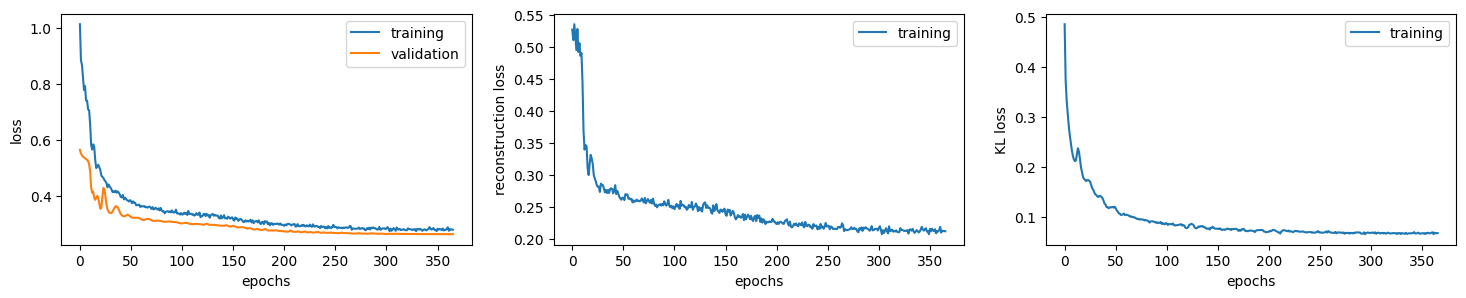

In [6]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()